## Window size evaluation

In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from copy import deepcopy as copy
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as MSE
plt.rcParams["figure.figsize"] = (14, 10)
plt.rcParams["figure.dpi"] = 200
plt.style.use("seaborn");plt.style.use("classic")
from itertools import product
%config InlineBackend.figure_format='retina'

In [2]:
def impute_outliers(df, q):
    df2 = df.copy()
    extreme_outliers = (df2 > df.quantile(q))
    df2[extreme_outliers] = np.nan
    df2.fillna(method="ffill", inplace=True)  
    return df2

def detrend(data):
    X = [i for i in range(0, len(data))]
    X = np.reshape(X, (len(X), 1))
    y = data.values
    model = LinearRegression()
    model.fit(X, y)
    trend = model.predict(X)
    detrended = [y[i]-trend[i] for i in range(0, len(data))]
    return pd.DataFrame(detrended, columns = data.columns, index=data.index)
    
    

In [3]:
#load data
with open("data_w", "rb") as f:
    data_w = pickle.load(f)
    
with open("data_2w", "rb") as f:
    data_2w = pickle.load(f)
    
with open("data_3w", "rb") as f:
    data_3w = pickle.load(f)
    
with open("data_m", "rb") as f:
    data_m = pickle.load(f)
    
cities = list(data_m.keys())

#Important Analysis parameters
starting_year = "2008"
target_vector = ['create', 'modify','tag_add',
            'tag_del', 'tag_change','loc_change',
            'new_mapper']

outlier_threshold = .99
detrend_data=False

for dat in [data_w, data_2w, data_3w, data_m]:
    for c in dat:
        dat[c] = impute_outliers(dat[c][target_vector][starting_year:], outlier_threshold).dropna()
        
# Leave out the very last year out for later testing
for c in data_w:
    data_w[c] = data_w[c][:-52]
for c in data_2w:
    data_2w[c] = data_2w[c][:-26]
for c in data_3w:
    data_3w[c] = data_3w[c][:-17]
for c in data_m:
    data_m[c] = data_m[c][:-12]

In [4]:
def pred_MA(data, window, test_size):
    return data[-test_size-window:].shift(1).rolling(window).mean().dropna()

In [8]:
def evaluate_windows(window_range=range(2,11)):
    results = list()
    for frequency in ["1w", "2w", "3w", "4w"]:
        for city in cities:
            for window in window_range:
                if frequency == "1w":
                    data = data_w[city].copy()
                    test_size = 96 
                elif frequency == "2w":
                    data = data_2w[city].copy()
                    test_size = 48
                elif frequency == "3w":
                    test_size = 34
                    data = data_3w[city].copy()
                elif frequency == "4w":
                    data = data_m[city].copy()
                    test_size = 24
                    
                RMSE_bl = np.sqrt(((data[-test_size:] - data[-test_size-1:].shift(1).dropna())**2).mean())
                RMSE_MA = np.sqrt(((data[-test_size:] - pred_MA(data, window, test_size))**2).mean())
                normalized_error = RMSE_MA / RMSE_bl
                #print(normalized_error.mean())
                
                
                
                results.append({"freq" : frequency, "window" : window, 
                                "E" : normalized_error.mean()})
                
    return pd.DataFrame(results)

In [9]:
res = evaluate_windows()

Text(0.5, 1.0, 'Moving Average - Lagged Window Evaluation')

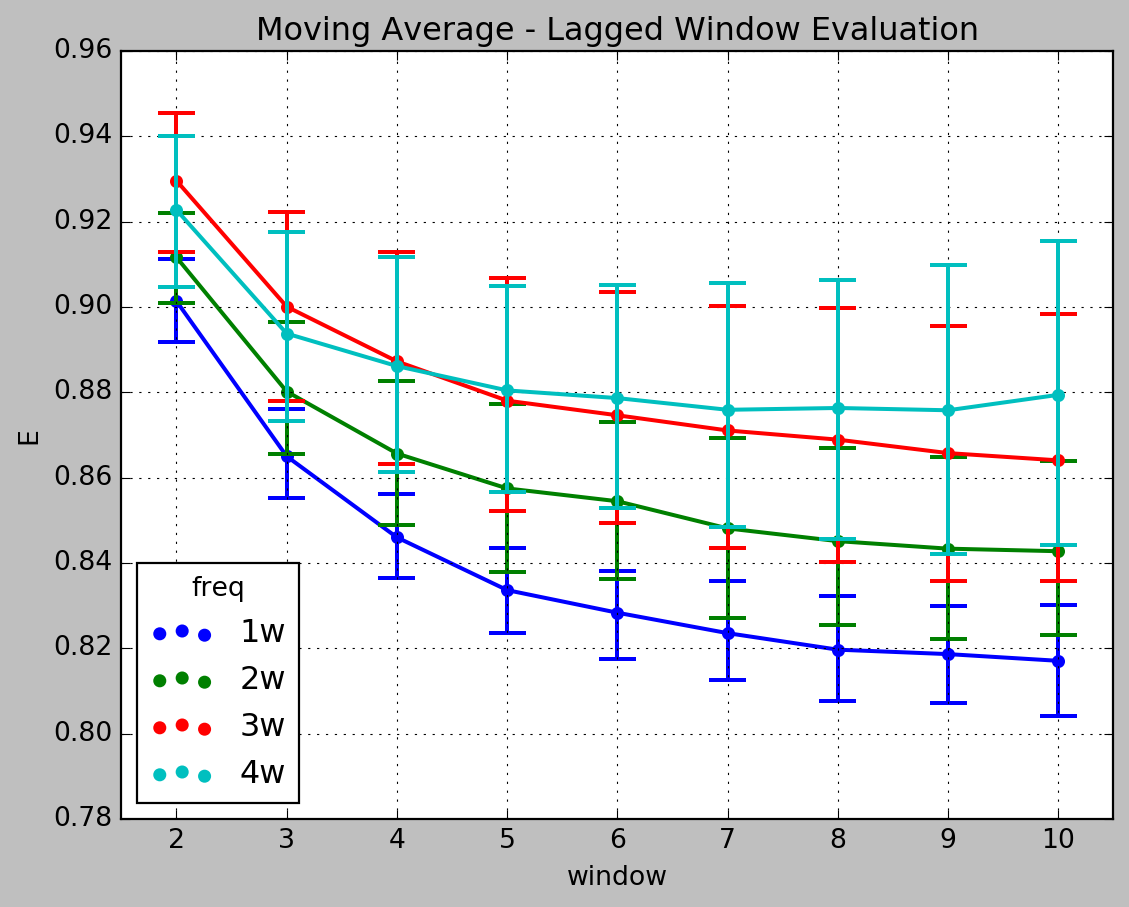

In [10]:
import seaborn as sns
sns.pointplot(data=res, y="E", x="window", hue="freq", capsize=.3);plt.grid();
plt.title("Moving Average - Lagged Window Evaluation")

In [11]:
def expo_weights(T,alpha):
    t = np.array(list(range(1,T+1)))
    return np.flip(((1-alpha)*alpha**t / (1-alpha)**T)/((1-alpha)*alpha**t / (1-alpha)**T).sum())
def linear_weights(T):
    t = np.array(list(range(1,T+1)))
    return t / t.sum()

def pred_WMA(data, window, test_size, weights,alpha=None):
    preds, index = list(), list()
    df = data[-test_size-window:].copy()
    df_test = data[-test_size:].copy()
    for i in range(window, len(df)):
        now = df.iloc[i]
        prev = df.iloc[i-window:i]
        if weights == "exponential":
            prediction = prev.apply(lambda x : x*expo_weights(window, alpha)).sum()
        elif weights == "linear":
            prediction = prev.apply(lambda x : x*linear_weights(window)).sum()
        else:
            raise Exception("Unknown weight method.")
        date = df.index[i]
        preds.append(prediction)
        index.append(date)
    return pd.DataFrame(preds, index=index)

### Window size evaluation for exponential weighted avg with $\alpha$

In [20]:
def evaluate_expo(window_range=range(2,11), alpha_range=[0.25, 0.5, 0.75]):
    results = list()
    for frequency in ["1w", "2w", "3w", "4w"]:
        for city in cities:
            for window in window_range:
                for alpha in alpha_range:
                    if frequency == "1w":
                        data = data_w[city].copy()
                        test_size = 96 
                    elif frequency == "2w":
                        data = data_2w[city].copy()
                        test_size = 48
                    elif frequency == "3w":
                        test_size = 34
                        data = data_3w[city].copy()
                    elif frequency == "4w":
                        data = data_m[city].copy()
                        test_size = 24

                    RMSE_bl = np.sqrt(((data[-test_size:] - data[-test_size-1:].shift(1).dropna())**2).mean())
                    RMSE_WMA = np.sqrt(((data[-test_size:] - pred_WMA(data, window, test_size, weights="exponential",alpha=alpha))**2).mean())
                    normalized_error = RMSE_WMA / RMSE_bl
                    #print(normalized_error.mean())



                    results.append({"freq" : frequency, "window" : window, "alpha" : alpha,
                                    "E" : normalized_error.mean()})
                
    return pd.DataFrame(results)

In [21]:
res = evaluate_expo()

Text(0.5, 1.0, 'EWMA Lagged Window Evaluation (alpha = 0.25)')

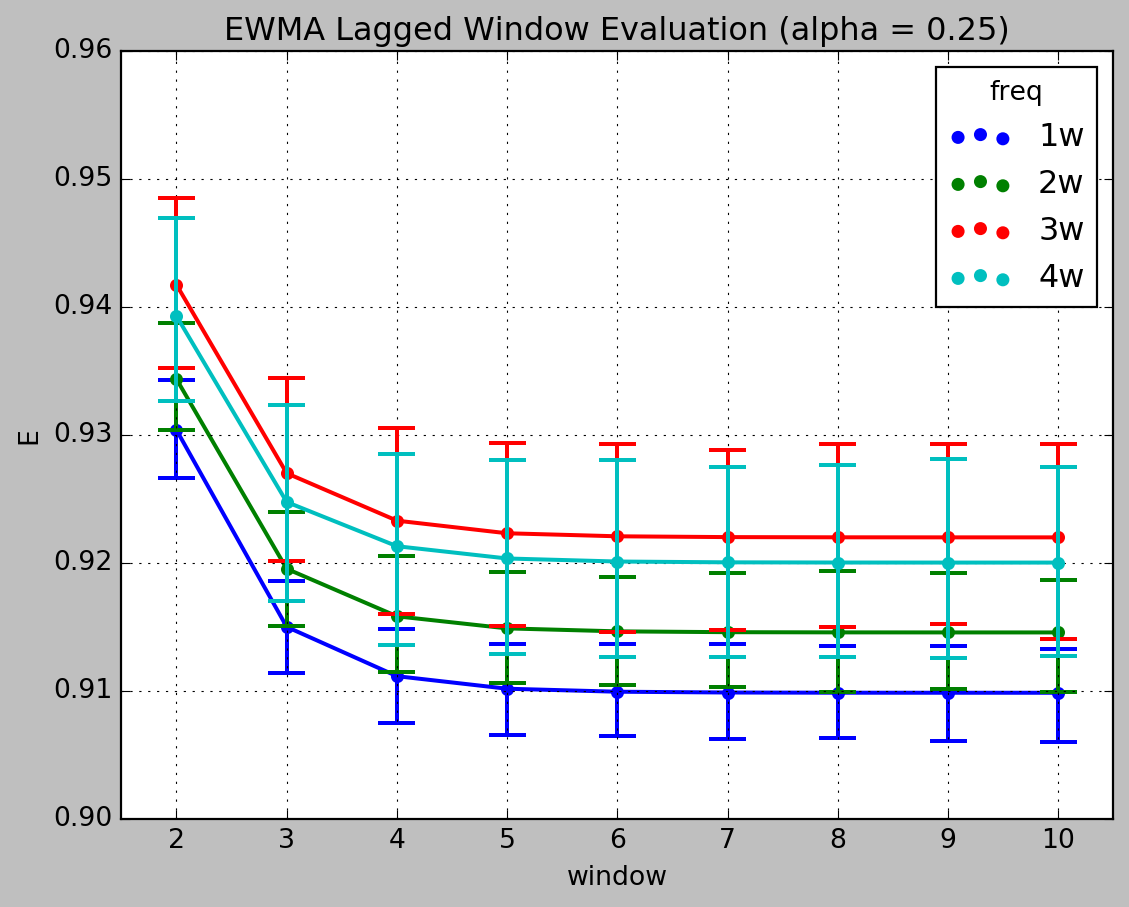

In [22]:

sns.pointplot(data=res[res.alpha==.25], y="E", x="window", hue="freq", capsize=.3);plt.grid();
plt.title("EWMA Lagged Window Evaluation (alpha = 0.25)")

Text(0.5, 1.0, 'EWMA Lagged Window Evaluation (alpha = 0.5)')

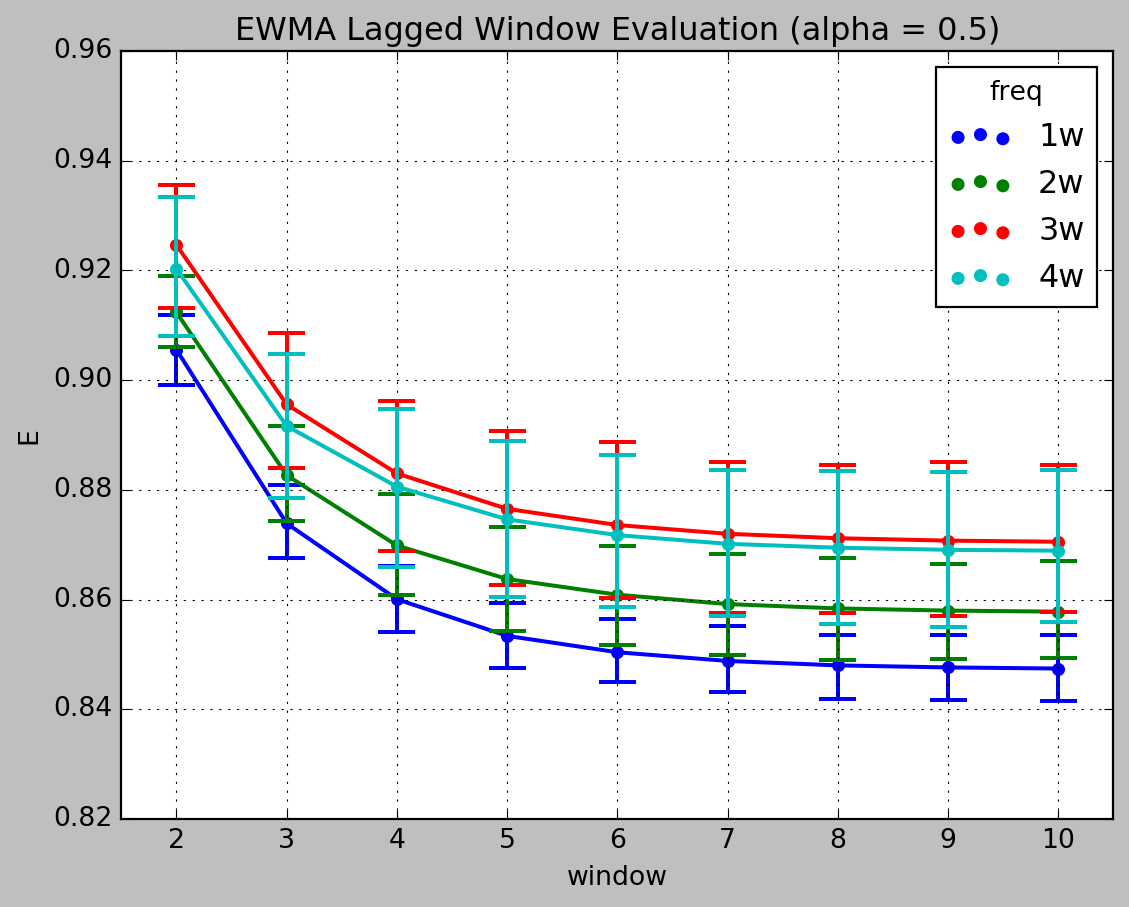

In [23]:

sns.pointplot(data=res[res.alpha==.5], y="E", x="window", hue="freq", capsize=.3);plt.grid();
plt.title("EWMA Lagged Window Evaluation (alpha = 0.5)")

Text(0.5, 1.0, 'EWMA Lagged Window Evaluation (alpha = 0.75)')

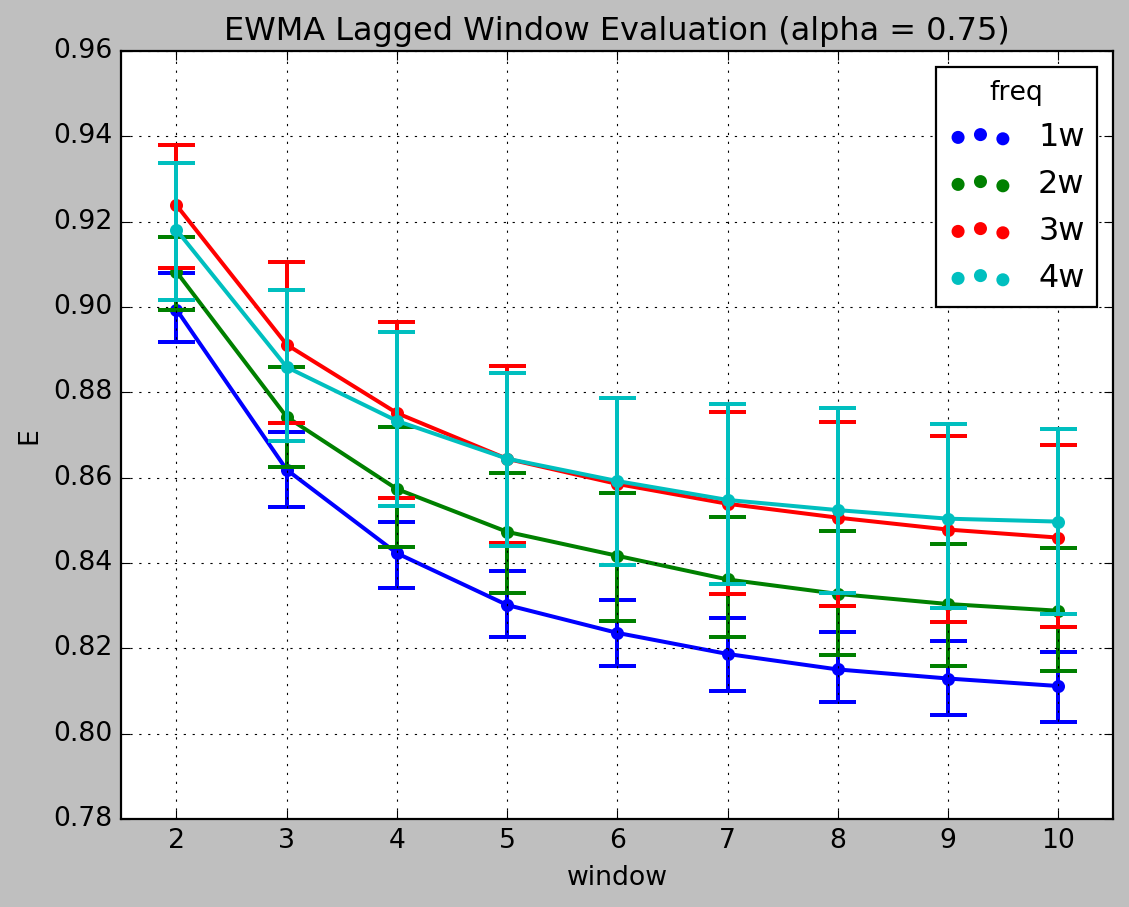

In [24]:

sns.pointplot(data=res[res.alpha==.75], y="E", x="window", hue="freq", capsize=.3);plt.grid();
plt.title("EWMA Lagged Window Evaluation (alpha = 0.75)")

### Window size evaluation for linear weighted avg

In [25]:
def evaluate_lin(window_range=range(2,11)):
    results = list()
    for frequency in ["1w", "2w", "3w", "4w"]:
        for city in cities:
            for window in window_range:
                if frequency == "1w":
                    data = data_w[city].copy()
                    test_size = 96 
                elif frequency == "2w":
                    data = data_2w[city].copy()
                    test_size = 48
                elif frequency == "3w":
                    test_size = 34
                    data = data_3w[city].copy()
                elif frequency == "4w":
                    data = data_m[city].copy()
                    test_size = 24

                RMSE_bl = np.sqrt(((data[-test_size:] - data[-test_size-1:].shift(1).dropna())**2).mean())
                RMSE_WMA = np.sqrt(((data[-test_size:] - pred_WMA(data, window, test_size, weights="linear",alpha=None))**2).mean())
                normalized_error = RMSE_WMA / RMSE_bl
                #print(normalized_error.mean())



                results.append({"freq" : frequency, "window" : window,
                                "E" : normalized_error.mean()})
                
    return pd.DataFrame(results)

In [26]:
res = evaluate_lin()

Text(0.5, 1.0, 'LWMA Lagged Window Evaluation ')

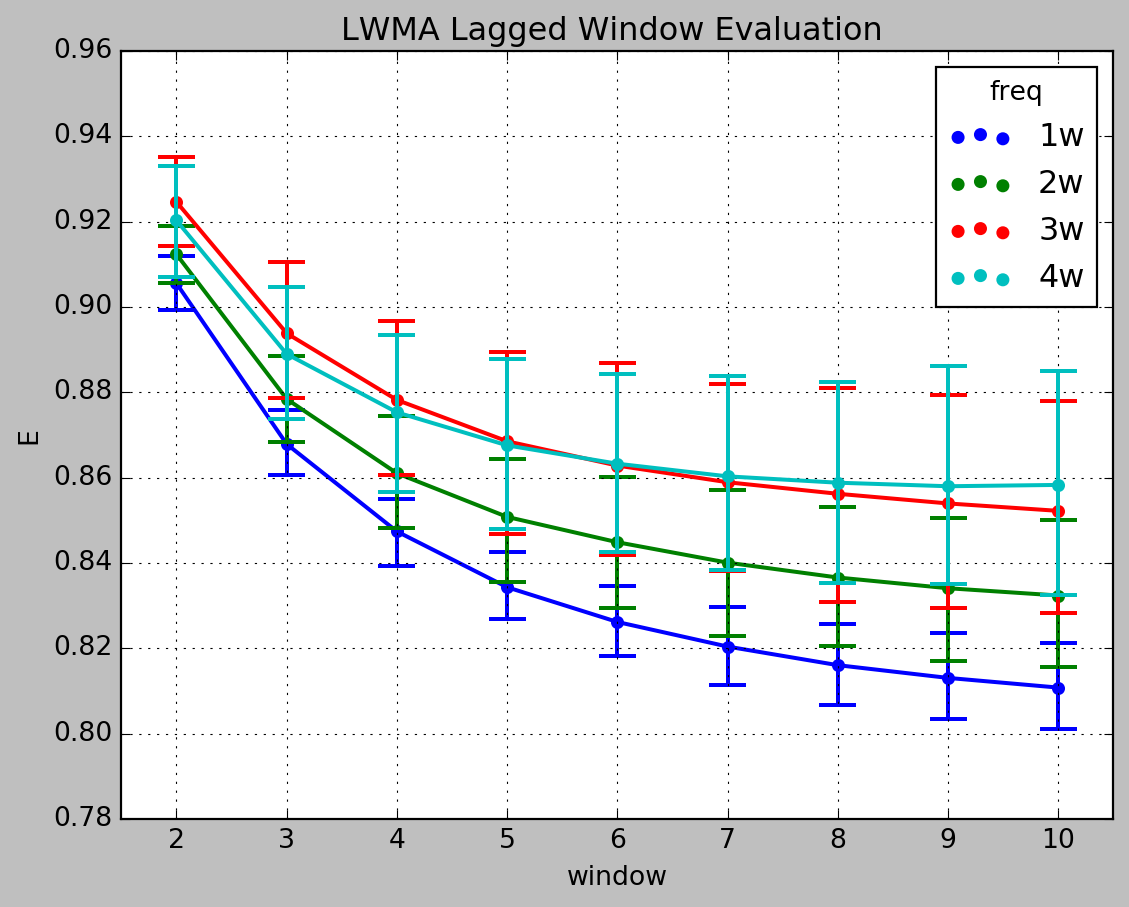

In [27]:

sns.pointplot(data=res, y="E", x="window", hue="freq", capsize=.3);plt.grid();
plt.title("LWMA Lagged Window Evaluation ")